<a href="https://colab.research.google.com/github/austiezr/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/LS_DS_231_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [x] Choose your target. Which column in your tabular dataset will you predict?
    - Whether a student improves their scores or not
- [x] Is your problem regression or classification?
    - Classification
- [x] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - 2
    - Slightly
- [x] Choose your evaluation metric(s).
    - Accuracy
- [x] Choose which observations you will use to train, validate, and test your model.
    - Randomized Cross-Validation Split
- [x] Begin to clean and explore your data.
- [x] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [65]:
!pip3 install category_encoders
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression, f_classif
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA

In [0]:
df = pd.read_csv('/Users/austie/Downloads/student/student-mat.csv', sep=';')
df1 = pd.read_csv('/Users/austie/Downloads/student/student-por.csv', sep=';')

In [0]:
df = df.append(df1, ignore_index=True)

In [68]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [70]:
df['famsize'] = df['famsize'].map({'GT3': 1, 'LE3':0})
df['address'] = df['address'].map({'U':1, 'R':0})
df['Pstatus'] = df['Pstatus'].map({'A': 0, 'T':1})
for col in ['schoolsup', 'famsup', 'paid', 'activities', 
            'nursery', 'higher', 'internet', 'romantic']:
  df[col] = df[col].map({'yes':1, 'no':0})

for col in ['G1', 'G2', 'G3']:
  df[col] = df[col].replace({0: np.NaN})

dfmean = df[['G1', 'G2', 'G3']]
dfmean['Mean'] = dfmean.mean(axis=1)
df['Mean'] = dfmean['Mean']
df['Pass/Fail'] = df['G3']>=10

df['Improved'] = (df['G3']-df['Mean'])>0

df = df.drop(columns=['school'])

training, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=33)
train, val = train_test_split(training, train_size=0.80, test_size=0.20, random_state=33)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 34 columns):
age           1044 non-null int64
address       1044 non-null int64
famsize       1044 non-null int64
Pstatus       1044 non-null int64
Medu          1044 non-null int64
Fedu          1044 non-null int64
Mjob          1044 non-null object
Fjob          1044 non-null object
reason        1044 non-null object
guardian      1044 non-null object
traveltime    1044 non-null int64
studytime     1044 non-null int64
failures      1044 non-null int64
schoolsup     1044 non-null int64
famsup        1044 non-null int64
paid          1044 non-null int64
activities    1044 non-null int64
nursery       1044 non-null int64
higher        1044 non-null int64
internet      1044 non-null int64
romantic      1044 non-null int64
famrel        1044 non-null int64
freetime      1044 non-null int64
goout         1044 non-null int64
Dalc          1044 non-null int64
Walc          1044 non-null int64
healt

In [0]:
target = 'Improved'
features = train.drop(columns=[target, 'G1', 'G2', 'Mean']).columns
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]
X_training = training[features]
y_training = training[target]

In [72]:
df[target].value_counts(normalize=True)

True     0.536398
False    0.463602
Name: Improved, dtype: float64

In [9]:
X_train.head()

,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Mean
384,18,0,1,1,4,2,other,other,home,father,...,0,0,5,4,3,4,3,3,14,5.5
238,17,0,1,1,2,1,at_home,services,course,mother,...,0,0,2,1,1,1,1,3,2,12.0
85,15,1,1,1,4,4,services,services,reputation,father,...,1,1,4,4,4,2,3,5,6,8.0
322,17,0,0,1,2,2,services,services,course,mother,...,1,0,3,3,2,2,2,3,3,11.0
20,15,1,1,1,4,3,teacher,other,reputation,mother,...,1,0,4,4,1,1,1,1,0,13.5


In [73]:
pipe = make_pipeline(
    OrdinalEncoder(),
    IterativeImputer(random_state=33),
    RandomForestClassifier(n_jobs=-1,
                          random_state=33,
                          min_samples_leaf=1,
                          n_estimators=100,
                          max_features='auto',
                          max_depth=10)
    )


pipe.fit(X_training, y_training)

print(f'Train MAE: {pipe.score(X_training, y_training)}\n')
print(f'Test MAE: {pipe.score(X_test, y_test)}')

Train MAE: 0.9604790419161676

Test MAE: 0.6411483253588517


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-2)]: Done  47 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-2)]: Done  71 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-2)]: Done  84 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-2)]: Done  99 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-2)]: Done 131 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-2)]: Done 167 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   

{'randomforestclassifier__max_depth': 393, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 28, 'randomforestclassifier__n_estimators': 79, 'simpleimputer__strategy': 'median', 'targetencoder__min_samples_leaf': 20}

Train Accuracy: 0.6922155688622754

Test Accuracy: 0.645933014354067


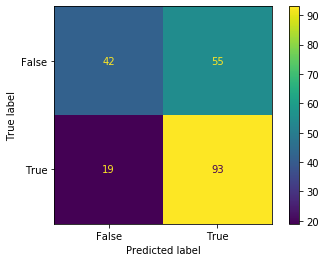

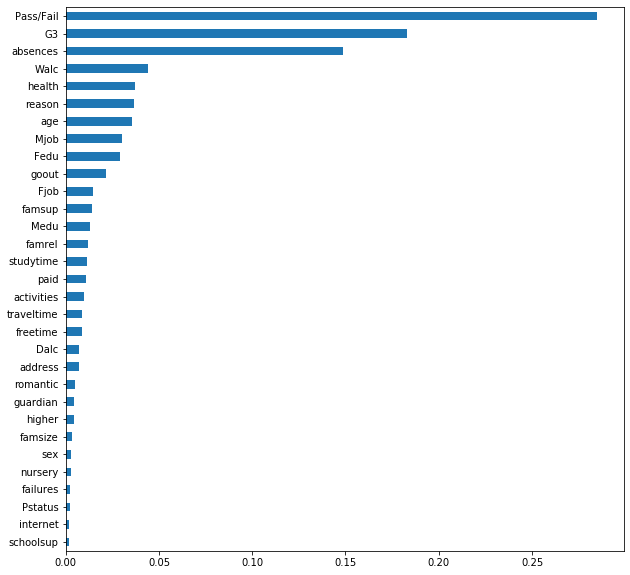

In [74]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=33,
                           n_jobs=-1)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1,100),
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'randomforestclassifier__n_estimators': randint(1, 500),
    'randomforestclassifier__min_samples_leaf': randint(1, 100),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None],
    'randomforestclassifier__max_depth': randint(1, 500)
}

search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-2
)

search.fit(X_training, y_training)

pipe = search.best_estimator_

print(f'{search.best_params_}\n')

print(f'Train Accuracy: {pipe.score(X_training, y_training)}\n')
print(f'Test Accuracy: {pipe.score(X_test, y_test)}')

plot_confusion_matrix(estimator=pipe, X=X_test, y_true=y_test)

encoder = pipe.named_steps['targetencoder']
encoded_columns = encoder.transform(X_training).columns
importances = pd.Series(pipe.named_steps.randomforestclassifier.feature_importances_, encoded_columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh();

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Batch computation too fast (0.1767s.) Setting batch_size=2.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done  40 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-2)]: Done  80 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done 102 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-2)]: Done 128 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-2)]: Done 154 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-2)]: Done 184 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done 214 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-2)]: Done 248 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done 282 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-2)]: Done 320 tas

{'ridgeclassifiercv__normalize': True, 'simpleimputer__strategy': 'most_frequent', 'targetencoder__min_samples_leaf': 75}

Train Accuracy: 0.6359281437125749

Test Accuracy: 0.645933014354067


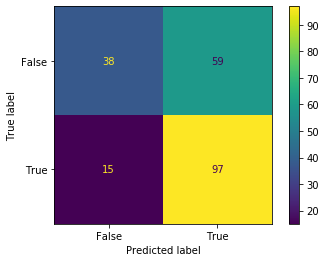

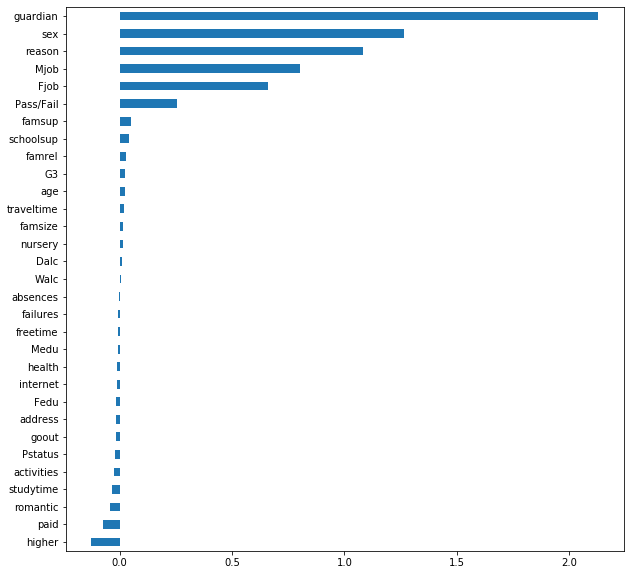

In [76]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    RidgeClassifierCV()
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1,100),
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'ridgeclassifiercv__normalize': [True, False]
}

search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-2
)

search.fit(X_training, y_training)

pipe = search.best_estimator_

print(f'{search.best_params_}\n')

print(f'Train Accuracy: {pipe.score(X_training, y_training)}\n')
print(f'Test Accuracy: {pipe.score(X_test, y_test)}')

plot_confusion_matrix(estimator=pipe, X=X_test, y_true=y_test)

encoder = pipe.named_steps['targetencoder']
encoded_columns = encoder.transform(X_training).columns
importances = pd.Series(pipe.named_steps.ridgeclassifiercv.coef_[0][:], encoded_columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh();